In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import acf,pacf
from time import time

In [275]:
#Function to parse the data from string to date format
def parser(s):
    return datetime.strptime(s,"%Y-%m-%d")

In [277]:
#Reading the data
aapl = pd.read_csv('apple_stock.csv',parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\Neha\AppData\Local\Temp\ipykernel_20616\2499919604.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  aapl = pd.read_csv('apple_stock.csv',parse_dates=[0], index_col=0, date_parser=parser)


In [17]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.318729,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.938305,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.030676,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.908880,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,17.015959,258529600


In [279]:
df = aapl[['Close']]

In [91]:
df.head()

,Close
2014-01-02,19.754642
2014-01-03,19.320715
2014-01-04,19.426071
2014-01-05,19.426071
2014-01-06,19.426071


In [288]:
df.loc['2014-10-01']

Close    24.795
Name: 2014-10-01 00:00:00, dtype: float64

In [286]:
df.tail()

,Close
2023-10-27,168.220001
2023-10-28,NaN
2023-10-29,NaN
2023-10-30,170.289993
2023-10-31,170.770004


## EDA 

In [45]:
df.describe()

,Close
count,2475.000000
mean,76.064199
std,54.787600
min,17.849285
25%,29.707500
50%,47.599998
75%,132.029999
max,196.449997


### There are missing dates in the data as every Saturday and Sunday are holidays for the stock market. We need to fill the data as these missing values will cause a problem for the model.

In [282]:
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

In [27]:
full_date_range

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11',
               ...
               '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', length=3590, freq='D')

In [284]:
df = df.reindex(full_date_range)

In [290]:
df.fillna(method='bfill', inplace=True)

C:\Users\Neha\AppData\Local\Temp\ipykernel_20616\3314729575.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [33]:
df.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11',
               ...
               '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', length=3590, freq='D')

In [35]:
df.head()

,Close
2014-01-02,19.754642
2014-01-03,19.320715
2014-01-04,19.426071
2014-01-05,19.426071
2014-01-06,19.426071


Lineplot of Close Price vs Year

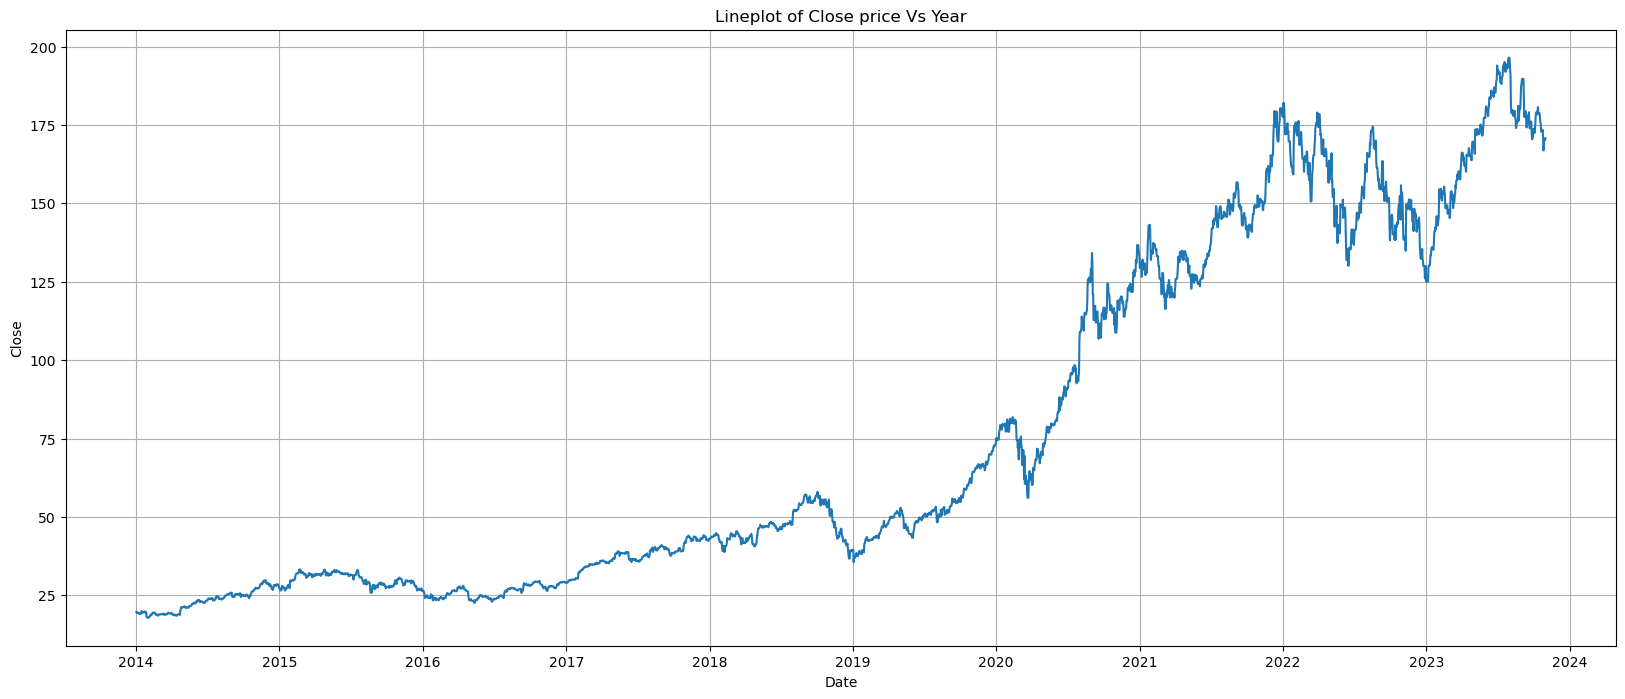

In [93]:
import seaborn as sns
plt.figure(figsize=(20,8))
sns.lineplot(x=df.index,y='Close',data=df)
plt.title('Lineplot of Close price Vs Year')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid()

Inf: We see an increasing trend of the stock price with volatility. We do not see any seasonality among the years.

Boxplot of Close Price Vs Year

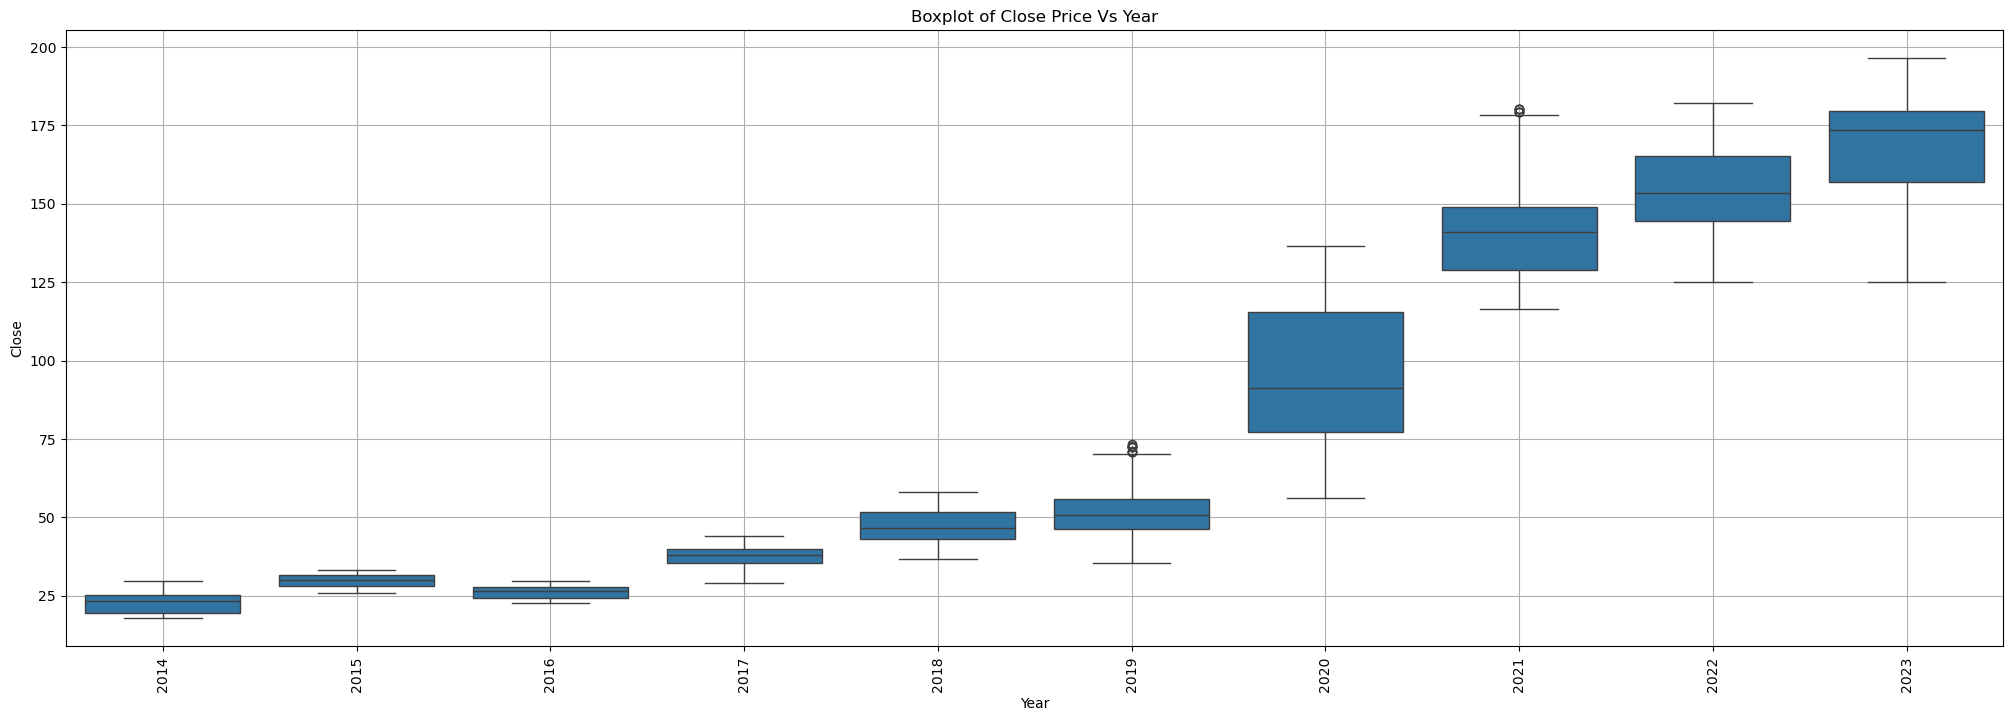

In [183]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year, y=df.values[:,0],ax=ax)
plt.title('Boxplot of Close Price Vs Year')
plt.xlabel('Year')
plt.ylabel('Close')
plt.xticks(rotation=90)
plt.grid()

Inf: We see that there are no outliers in most of the years signifying that there are very less sudden increase or drop in stock price.

Boxplot of Close Price per Month

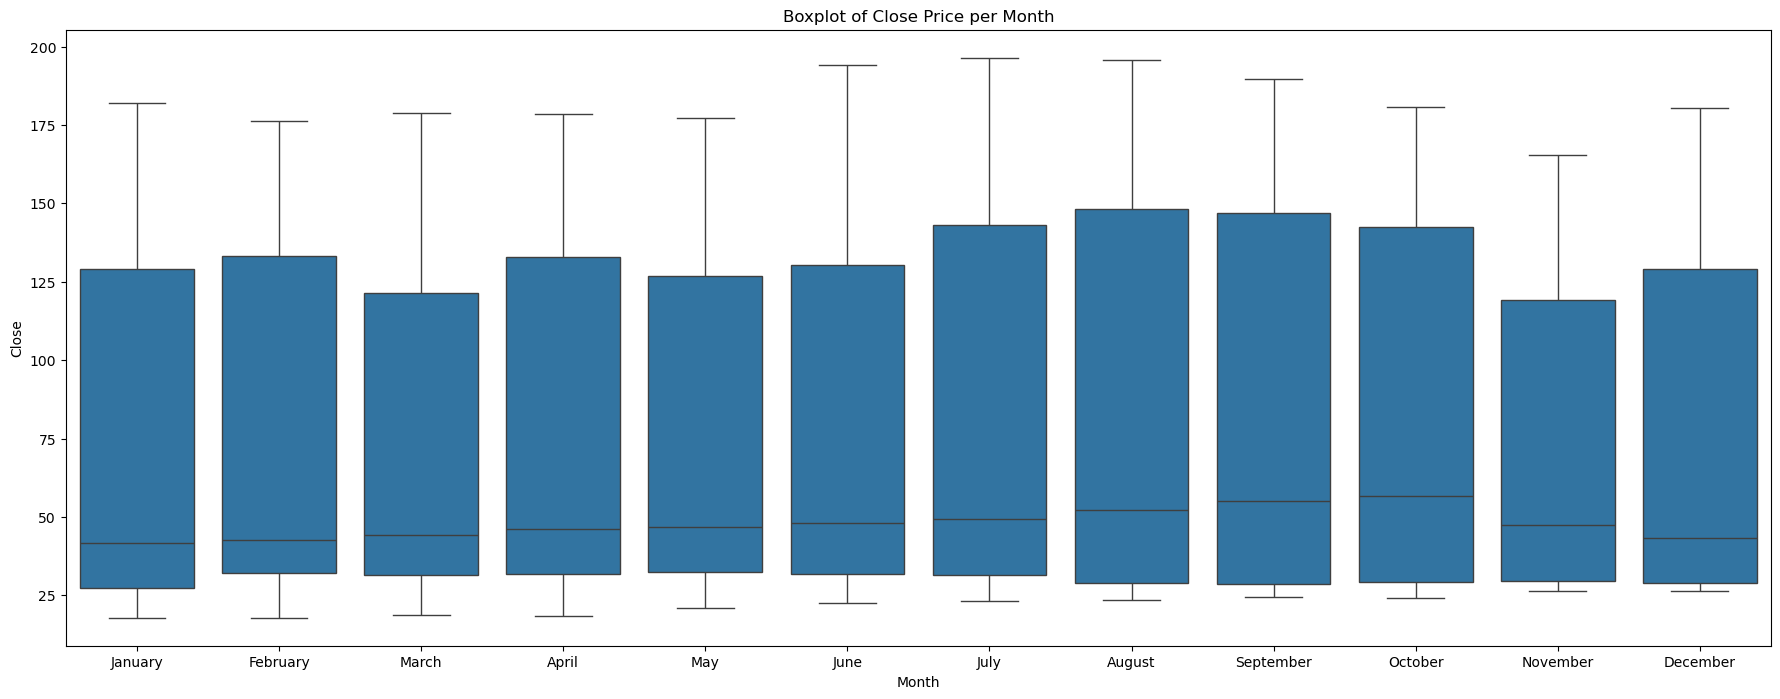

In [185]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x=df.index.month_name(), y=df.values[:,0],ax=ax)
plt.title('Boxplot of Close Price per Month')
plt.xlabel('Month')
plt.ylabel('Close')
plt.show()

Average Close Price of Each Year

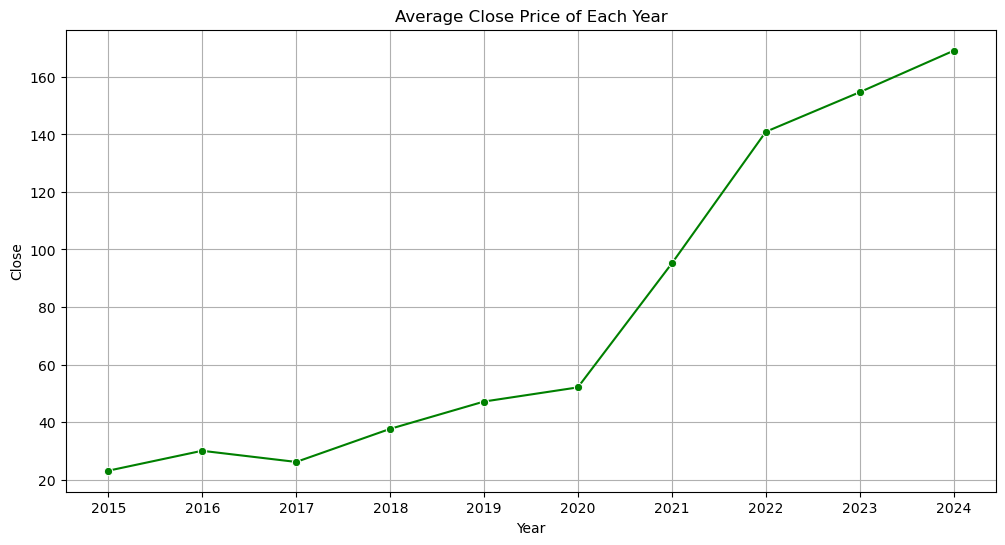

In [187]:
df_yearly_sum = df.resample('YE').mean()
plt.figure(figsize=(12,6))
sns.lineplot(x=df_yearly_sum.index, y='Close', data=df_yearly_sum, marker='o', color='green')
plt.title('Average Close Price of Each Year')
plt.xlabel('Year')
plt.ylabel('Close')
plt.grid()

Average Close Price quarterly since 2014

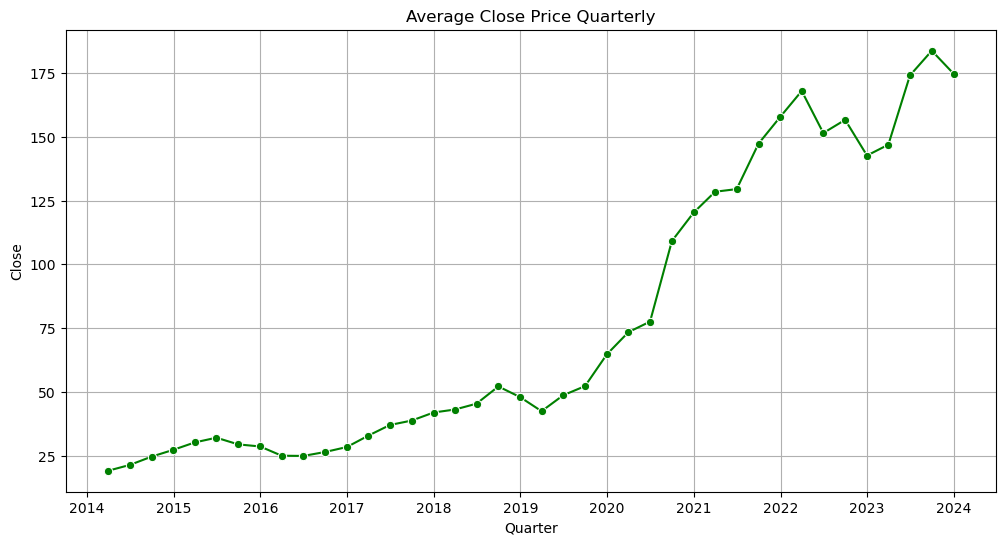

In [189]:
df_quarterly_sum = df.resample('QE').mean()
plt.figure(figsize=(12,6))
sns.lineplot(x=df_quarterly_sum.index, y='Close', data=df_quarterly_sum, marker='o', color='green')
plt.title('Average Close Price Quarterly')
plt.xlabel('Quarter')
plt.ylabel('Close')
plt.grid()

Augmented Dickey-Fuller Test - Let's run the Augmented Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [318]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df)
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -0.065
DF test p-value is 0.9528


The data is non-stationary and we can see clearly that there is an increasing trend in the data.

In [320]:
first_diff = df.diff()[1:]
dftest_1 = adfuller(first_diff)
print('DF test statistic is %3.3f' %dftest_1[0])
print('DF test p-value is %1.4f' %dftest_1[1])

DF test statistic is -16.333
DF test p-value is 0.0000


In [310]:
first_diff.std()

Close    1.437999
dtype: float64

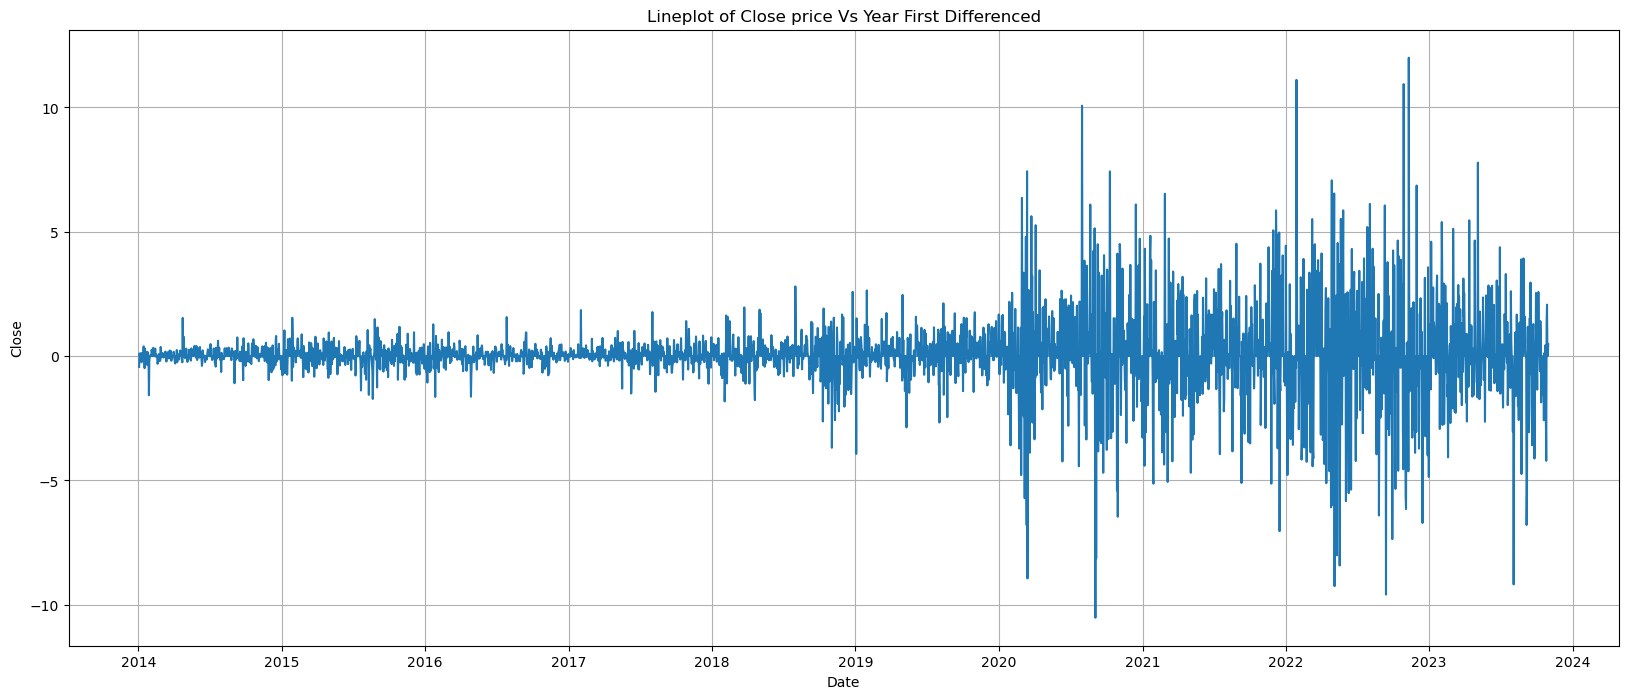

In [523]:
plt.figure(figsize=(20,8))
sns.lineplot(x=first_diff.index,y='Close',data=first_diff)
plt.title('Lineplot of Close price Vs Year First Differenced')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid()

In [525]:
first_diff.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
               '2014-01-11', '2014-01-12',
               ...
               '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', length=3589, freq='D')

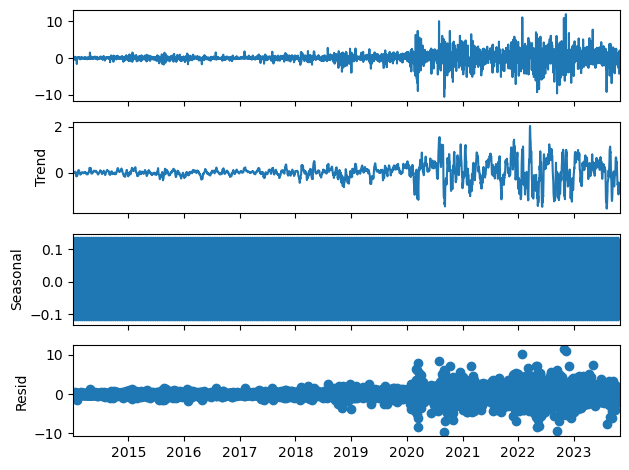

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_add_decompose = seasonal_decompose(first_diff,model='additive',period=12)

df_add_decompose.plot()
plt.show()

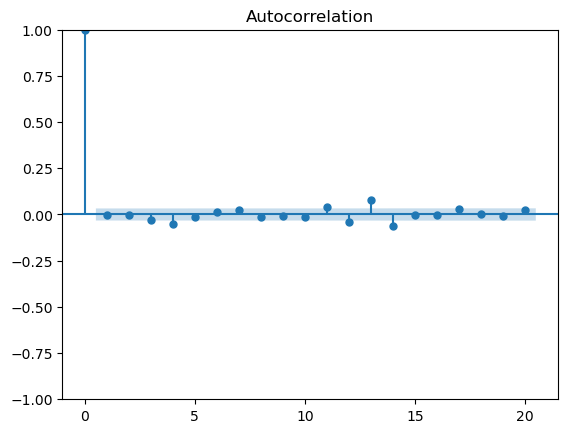

In [329]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_vals = acf(first_diff)
acf_plot = plot_acf(first_diff, lags=20)

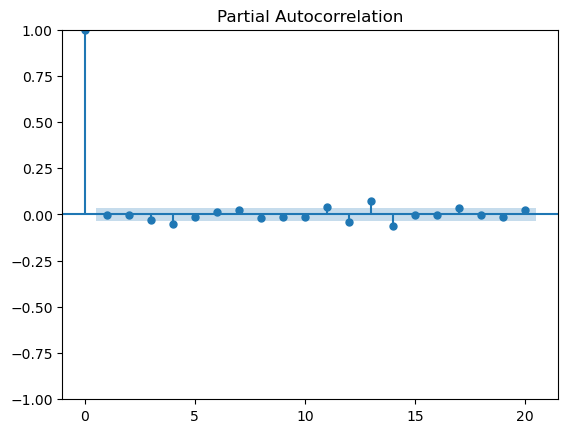

In [331]:
pacf_vals = pacf(first_diff)
pacf_plot = plot_pacf(first_diff, lags=20)

In [322]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

train_end = datetime(2023,9,30)
test_start = datetime(2023,10,1)
test_end = datetime(2023,10,31)

train_data = df[:train_end]
test_data = df[test_start:test_end]

In [324]:
train_data.tail()

,Close
2023-09-26,171.960007
2023-09-27,170.429993
2023-09-28,170.690002
2023-09-29,171.210007
2023-09-30,173.750000


In [575]:
test_data

,Close
2023-10-01,173.750000
2023-10-02,173.750000
2023-10-03,172.399994
2023-10-04,173.660004
2023-10-05,174.910004
2023-10-06,177.490005
2023-10-07,178.990005
2023-10-08,178.990005
2023-10-09,178.990005
2023-10-10,178.389999


In [326]:
arma_model = ARIMA(train_data,order=(4,1,0))

In [328]:
start = time()
arma_model_fit = arma_model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.49362730979919434


In [330]:
#Summarty of the model
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3559
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -6337.158
Date:                Mon, 16 Dec 2024   AIC                          12684.316
Time:                        09:01:59   BIC                          12715.201
Sample:                    01-02-2014   HQIC                         12695.330
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0037      0.009     -0.416      0.677      -0.021       0.014
ar.L2         -0.0003      0.010     -0.028      0.977      -0.020       0.019
ar.L3         -0.0264      0.012     -2.204      0.0

In [332]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date,pred_end_date)

2023-10-01 00:00:00 2023-10-31 00:00:00


In [334]:
test_data.index = test_data.index.date

In [336]:
#getting the predictions and residuals
predictions = arma_model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
test_data = test_data['Close']  
residuals = test_data - predictions

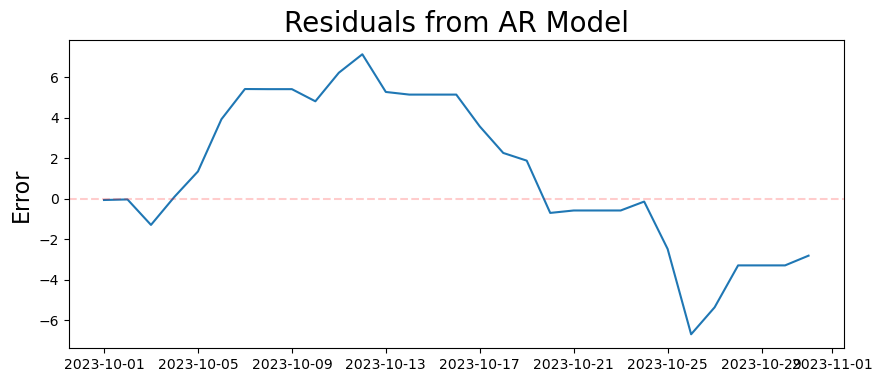

In [338]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Price')

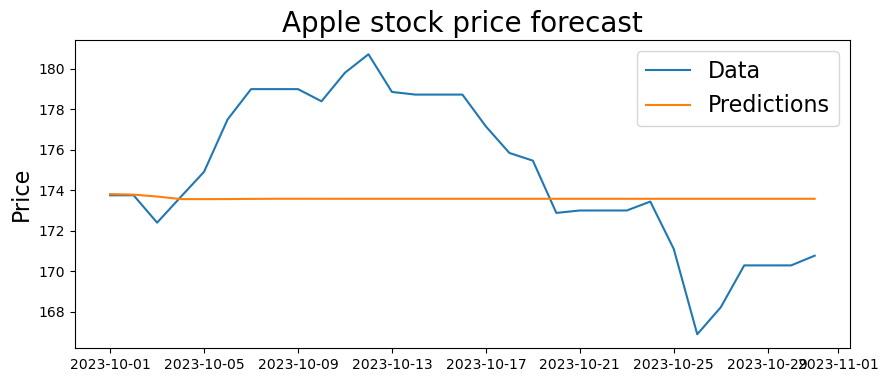

In [340]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Apple stock price forecast', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [360]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error
print('ARIMA RMSE:',root_mean_squared_error(test_data.values,predictions.values))
print('ARIMA MAPE:',mean_absolute_percentage_error(test_data.values,predictions.values))
test_scores = pd.DataFrame({'RMSE': root_mean_squared_error(test_data.values,predictions.values),'MAPE':mean_absolute_percentage_error(test_data.values,predictions.values)},index=['ARIMA_Nomral'])

ARIMA RMSE: 3.8917601743891876
ARIMA MAPE: 0.01823700021364967


In [362]:
test_scores

,RMSE,MAPE
ARIMA_Nomral,3.89176,0.018237


In [350]:
#Using Rolling Origin
from datetime import timedelta
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=(4,1,0))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred.iloc[0]

Text(0, 0.5, 'Price')

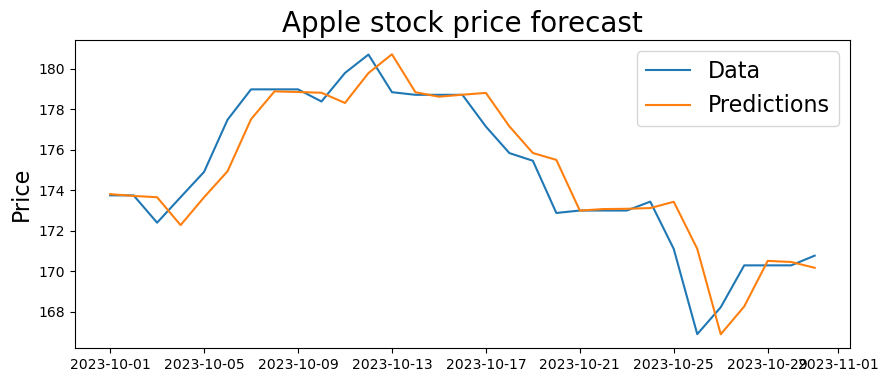

In [351]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Apple stock price forecast', fontsize=20)
plt.ylabel('Price', fontsize=16)

Text(0, 0.5, 'Error')

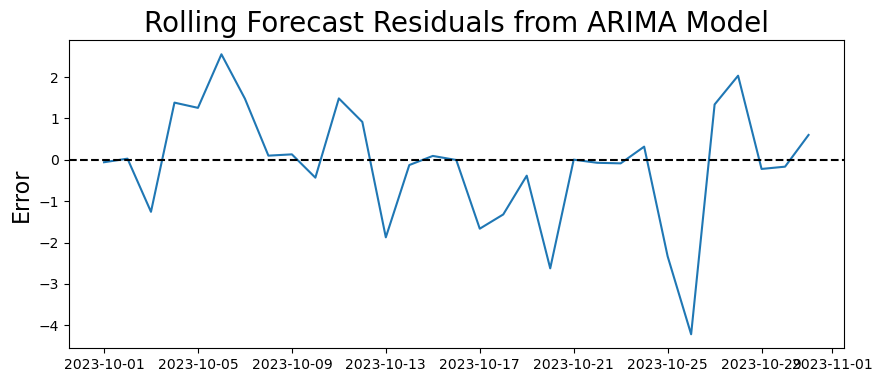

In [354]:
rolling_residuals = test_data - rolling_predictions
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [364]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error
print('ARIMA Rolling RMSE:',root_mean_squared_error(test_data.values,rolling_predictions.values))
print('ARIMA Rolling MAPE:',mean_absolute_percentage_error(test_data.values, rolling_predictions.values))
test_scores_temp = pd.DataFrame({'RMSE': root_mean_squared_error(test_data.values,rolling_predictions.values),'MAPE':mean_absolute_percentage_error(test_data.values,rolling_predictions.values)},index=['ARIMA_Rolling'])

ARIMA Rolling RMSE: 1.4114687669365396
ARIMA Rolling MAPE: 0.005673896424386815


In [366]:
test_scores = pd.concat([test_scores,test_scores_temp])

In [368]:
test_scores

,RMSE,MAPE
ARIMA_Nomral,3.891760,0.018237
ARIMA_Rolling,1.411469,0.005674


In [370]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [372]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [374]:
scaled_df = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

In [376]:
window_size = 14

def create_sequence(data,window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X,y = create_sequence(scaled_df,window_size)

In [378]:
X.shape, y.shape

((3576, 14, 1), (3576, 1))

In [380]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2860, 14, 1), (2860, 1), (716, 14, 1), (716, 1))

In [382]:
X_train.shape[1], X_train.shape[2], y_train.shape[1]

(14, 1, 1)

In [384]:
model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer
    keras.layers.Dense(y_train.shape[1])
])

C:\Users\Neha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [386]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [388]:
#Early stopping condition
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [390]:
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - RootMeanSquaredError: 0.2390 - loss: 0.0643 - val_RootMeanSquaredError: 0.0774 - val_loss: 0.0060
Epoch 2/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - RootMeanSquaredError: 0.1570 - loss: 0.0247 - val_RootMeanSquaredError: 0.1012 - val_loss: 0.0102
Epoch 3/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - RootMeanSquaredError: 0.1414 - loss: 0.0201 - val_RootMeanSquaredError: 0.0631 - val_loss: 0.0040
Epoch 4/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - RootMeanSquaredError: 0.1384 - loss: 0.0192 - val_RootMeanSquaredError: 0.0684 - val_loss: 0.0047
Epoch 5/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - RootMeanSquaredError: 0.1519 - loss: 0.0231 - val_RootMeanSquaredError: 0.1041 - val_loss: 0.0108
Epoch 6/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - RootMeanSquaredError: 0.1433 - loss: 0.0206 - val_RootMeanSquaredError: 0.0855 - val_loss: 0.0073
Epoch 7/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - RootMeanSquar

In [392]:
# Making predictions on the test data
predictions = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


In [394]:
# Inverse scaling to get the original values
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

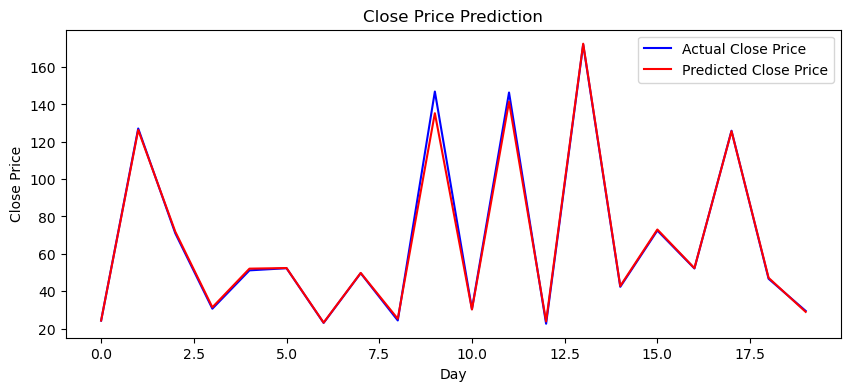

In [396]:
plt.figure(figsize=(10,4))
plt.plot(y_test_rescaled[:20], color='blue', label=f'Actual Close Price')
plt.plot(predictions[:20], color='red', label=f'Predicted Close Price')
plt.title(f'Close Price Prediction')
plt.xlabel('Day')
plt.ylabel(f'Close Price')
plt.legend()

In [404]:
print('LSTM RMSE:',root_mean_squared_error(y_test_rescaled,predictions))
print('LSTM MAPE:',mean_absolute_percentage_error(y_test_rescaled,predictions))
test_scores_temp = pd.DataFrame({'RMSE': root_mean_squared_error(y_test_rescaled,predictions),'MAPE':mean_absolute_percentage_error(y_test_rescaled,predictions)},index=['LSTM'])
test_scores = pd.concat([test_scores,test_scores_temp])
test_scores

LSTM RMSE: 1.7980729102959598
LSTM MAPE: 0.01926467717807717


,RMSE,MAPE
ARIMA_Nomral,3.891760,0.018237
ARIMA_Rolling,1.411469,0.005674
ARIMA_Rolling,1.411469,0.005674
LSTM,1.798073,0.019265


In [406]:
aapl_req = aapl[['Open','High','Low','Close']]

In [408]:
scaled_aapl = scaler.fit_transform(aapl_req)
scaled_aapl_df = pd.DataFrame(scaled_aapl, index=aapl_req.index, columns=aapl_req.columns)

In [410]:
scaled_aapl_df

,Open,High,Low,Close
Date,,,,
2014-01-02,-1.026152,-1.028408,-1.025405,-1.027987
2014-01-03,-1.027992,-1.030556,-1.033053,-1.035909
2014-01-06,-1.038049,-1.035006,-1.037559,-1.033985
2014-01-07,-1.033565,-1.035547,-1.034709,-1.036522
2014-01-08,-1.037161,-1.035805,-1.034201,-1.034292
...,...,...,...,...
2023-10-25,1.751846,1.737394,1.763298,1.734973
2023-10-26,1.724255,1.707058,1.671287,1.658115
2023-10-27,1.661033,1.663359,1.692720,1.682396


In [203]:
from statsmodels.tsa.vector_ar.var_model import

# Fit a Vector Autoregressive (VAR) model
model = VAR(scaled_aapl_df)
result = model.select_order(maxlags=20)  # Test up to 20 lags
print(result.summary())

C:\Users\Neha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -25.37      -25.36   9.630e-12      -25.36
1       -33.67      -33.62   2.394e-15      -33.65
2       -33.75      -33.66   2.209e-15      -33.72
3       -33.79     -33.67*   2.117e-15      -33.74
4       -33.81      -33.65   2.076e-15     -33.75*
5       -33.82      -33.62   2.058e-15      -33.74
6       -33.83      -33.59   2.034e-15      -33.74
7       -33.83      -33.55   2.038e-15      -33.73
8       -33.84      -33.52   2.020e-15      -33.72
9       -33.85      -33.50   1.989e-15      -33.72
10      -33.88      -33.49   1.940e-15      -33.74
11      -33.88      -33.46   1.925e-15      -33.73
12      -33.89      -33.42   1.917e-15      -33.72
13      -33.88      -33.38   1.932e-15      -33.70
14      -33.88      -33.34   1.932e-15      -33.68
15      -33.88      -33.30   1.938e-15      -33.67
16      -33.89      -33.27   1.

In [211]:
from statsmodels.tsa.stattools import grangercausalitytests

# Test Granger causality for each feature
for feature in scaled_aapl_df.columns.drop('Close'):
    print(f"Granger causality for {feature}:")
    grangercausalitytests(scaled_aapl_df[['Close', feature]], maxlag=4)

Granger causality for Open:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0019  , p=0.9649  , df_denom=2471, df_num=1
ssr based chi2 test:   chi2=0.0019  , p=0.9649  , df=1
likelihood ratio test: chi2=0.0019  , p=0.9649  , df=1
parameter F test:         F=0.0019  , p=0.9649  , df_denom=2471, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4888  , p=0.0113  , df_denom=2468, df_num=2
ssr based chi2 test:   chi2=8.9958  , p=0.0111  , df=2
likelihood ratio test: chi2=8.9795  , p=0.0112  , df=2
parameter F test:         F=4.4888  , p=0.0113  , df_denom=2468, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2383  , p=0.0818  , df_denom=2465, df_num=3
ssr based chi2 test:   chi2=6.7340  , p=0.0809  , df=3
likelihood ratio test: chi2=6.7248  , p=0.0812  , df=3
parameter F test:         F=2.2383  , p=0.0818  , df_denom=2465, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

In [412]:
window_size = 4

def create_sequence(data,window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X,y = create_sequence(scaled_aapl_df,window_size)

In [414]:
X.shape, y.shape

((2471, 4, 4), (2471, 4))

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1976, 4, 4), (1976, 4), (495, 4, 4), (495, 4))

In [418]:
X_train.shape[1], X_train.shape[2], y_train.shape[1]

(4, 4, 4)

In [420]:
model_mul = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer
    keras.layers.Dense(y_train.shape[1])
])

C:\Users\Neha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [422]:
#compilation
model_mul.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [424]:
history_mul = model_mul.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - RootMeanSquaredError: 0.3971 - loss: 0.1792 - val_RootMeanSquaredError: 0.0984 - val_loss: 0.0097
Epoch 2/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - RootMeanSquaredError: 0.1771 - loss: 0.0314 - val_RootMeanSquaredError: 0.1398 - val_loss: 0.0195
Epoch 3/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - RootMeanSquaredError: 0.1699 - loss: 0.0289 - val_RootMeanSquaredError: 0.0972 - val_loss: 0.0094
Epoch 4/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - RootMeanSquaredError: 0.1670 - loss: 0.0280 - val_RootMeanSquaredError: 0.0834 - val_loss: 0.0070
Epoch 5/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - RootMeanSquaredError: 0.1482 - loss: 0.0220 - val_RootMeanSquaredError: 0.0909 - val_loss: 0.0083
Epoch 6/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - RootMeanSquaredError: 0.1460 - loss: 0.0213 - val_RootMeanSquaredError: 0.0932 - val_loss: 0.0087
Epoch 7/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - RootMeanSquaredError: 0.14

In [426]:
predictions = model_mul.predict(X_test)
# Inverse scaling to get the original values
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


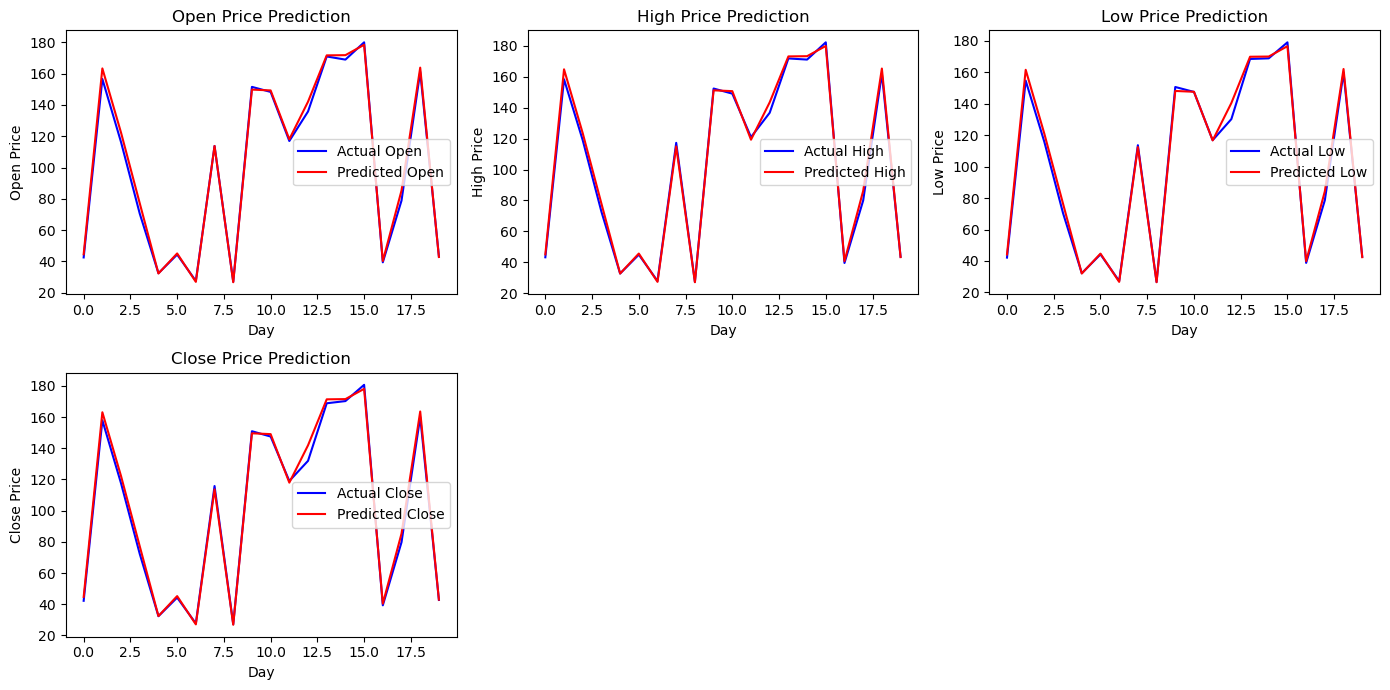

In [428]:
plt.figure(figsize=(14, 7))

for i, col in enumerate(scaled_aapl_df.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test_rescaled[:20, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:20, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Day')
    plt.ylabel(f'{col} Price')
    plt.legend()

plt.tight_layout()

In [430]:
print('LSTM RMSE:',root_mean_squared_error(y_test_rescaled[:,3],predictions[:,3]))
print('LSTM MAPE:',mean_absolute_percentage_error(y_test_rescaled[:,3],predictions[:,3]))
test_scores_temp = pd.DataFrame({'RMSE': root_mean_squared_error(y_test_rescaled[:,3],predictions[:,3]),'MAPE':mean_absolute_percentage_error(y_test_rescaled[:,3],predictions[:,3])},index=['LSTM Multivariate'])
test_scores = pd.concat([test_scores,test_scores_temp])
test_scores

LSTM RMSE: 2.7385216275662367
LSTM MAPE: 0.024686552062526575


,RMSE,MAPE
ARIMA_Nomral,3.891760,0.018237
ARIMA_Rolling,1.411469,0.005674
ARIMA_Rolling,1.411469,0.005674
LSTM,1.798073,0.019265
LSTM Multivariate,2.738522,0.024687


In [438]:
import pandas_ta as ta

In [444]:
aapl_req = aapl[['Open','High','Low','Close','Adj Close']]
aapl_req['RSI']=ta.rsi(aapl_req.Close, length=15)
aapl_req['EMAF']=ta.ema(aapl_req.Close, length=20)
aapl_req['EMAM']=ta.ema(aapl_req.Close, length=100)
aapl_req['EMAS']=ta.ema(aapl_req.Close, length=150)

aapl_req['Target'] = aapl_req['Adj Close']-aapl_req.Open
aapl_req['Target'] = aapl_req['Target'].shift(-1)

In [446]:
aapl_req

,Open,High,Low,Close,Adj Close,RSI,EMAF,EMAM,EMAS,Target
Date,,,,,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.318729,NaN,NaN,NaN,NaN,-2.806696
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.938305,NaN,NaN,NaN,NaN,-2.163967
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.030676,NaN,NaN,NaN,NaN,-2.531120
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.908880,NaN,NaN,NaN,NaN,-2.227255
2014-01-08,19.243214,19.484285,19.238930,19.409286,17.015959,NaN,NaN,NaN,NaN,-2.729906
...,...,...,...,...,...,...,...,...,...,...
2023-10-25,171.880005,173.059998,170.649994,171.100006,170.874893,37.873384,175.424545,177.150953,174.603562,-3.699570
2023-10-26,170.369995,171.380005,165.669998,166.889999,166.670425,31.412667,174.611731,176.947765,174.501395,1.088669
2023-10-27,166.910004,168.960007,166.830002,168.220001,167.998672,35.156738,174.002995,176.774938,174.418198,1.045929


In [450]:
aapl_req.dropna(inplace=True)
aapl_req.reset_index(inplace = True)
aapl_req.drop(['Close', 'Date'], axis=1, inplace=True)

In [460]:
aapl_req.drop('index', axis=1, inplace=True)

In [462]:
aapl_req

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target
0,23.687500,23.870001,23.677500,21.054182,50.075969,23.903334,22.073109,20.815405,-2.680542
1,23.732500,23.987499,23.525000,21.051958,47.998875,23.876350,22.103741,20.852552,-2.455116
2,23.565001,23.705000,23.320000,21.109884,49.221234,23.858126,22.135053,20.890068,-2.429090
3,23.817499,24.020000,23.709999,21.388409,54.705752,23.871400,22.171933,20.931226,-2.626051
4,24.010000,24.219999,23.902500,21.383949,54.604665,23.882933,22.207984,20.971772,-2.370569
...,...,...,...,...,...,...,...,...,...
2320,173.050003,173.669998,171.449997,173.211807,42.396936,175.879760,177.273194,174.650589,-1.005112
2321,171.880005,173.059998,170.649994,170.874893,37.873384,175.424545,177.150953,174.603562,-3.699570
2322,170.369995,171.380005,165.669998,166.670425,31.412667,174.611731,176.947765,174.501395,1.088669
2323,166.910004,168.960007,166.830002,167.998672,35.156738,174.002995,176.774938,174.418198,1.045929


In [466]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
aapl_scaled = sc.fit_transform(aapl_req)

In [472]:
aapl_scaled = pd.DataFrame(aapl_scaled, index=aapl_req.index, columns=aapl_req.columns)

In [480]:
def create_sequence(data, window_size, target_col):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].drop(columns=[target_col]).values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

X, y = create_sequence(aapl_scaled, window_size=14, target_col="Target")

In [488]:
X.shape, y.shape

((2311, 14, 8), (2311, 1))

In [486]:
y = np.reshape(y,(len(y),1))

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1848, 14, 8), (1848, 1), (463, 14, 8), (463, 1))

In [492]:
model_mul_fe = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    # Adding a Dense output layer
    keras.layers.Dense(y_train.shape[1])
])

C:\Users\Neha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [494]:
model_mul_fe.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [498]:
history_mul_fe = model_mul_fe.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - RootMeanSquaredError: 0.1281 - loss: 0.0171 - val_RootMeanSquaredError: 0.0911 - val_loss: 0.0083
Epoch 2/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.1019 - loss: 0.0104 - val_RootMeanSquaredError: 0.0919 - val_loss: 0.0084
Epoch 3/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - RootMeanSquaredError: 0.0906 - loss: 0.0082 - val_RootMeanSquaredError: 0.0935 - val_loss: 0.0087
Epoch 4/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0926 - loss: 0.0086 - val_RootMeanSquaredError: 0.0915 - val_loss: 0.0084
Epoch 5/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - RootMeanSquaredError: 0.0953 - loss: 0.0091 - val_RootMeanSquaredError: 0.0907 - val_loss: 0.0082
Epoch 6/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - RootMeanSquaredError: 0.0924 - loss: 0.0086 - val_RootMeanSquaredError: 0.0910 - val_loss: 0.0083
Epoch 7/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - RootMeanSquaredEr

In [502]:
predictions = model_mul_fe.predict(X_test)
# Inverse scaling to get the original values
#predictions = sc.inverse_transform(predictions)
#y_test_rescaled = sc.inverse_transform(y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


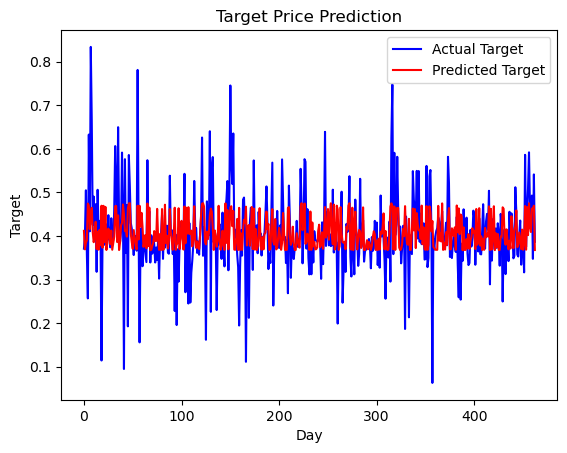

In [504]:
plt.plot(y_test, color='blue', label='Actual Target')
plt.plot(predictions, color='red', label='Predicted Target')
plt.title('Target Price Prediction')
plt.xlabel('Day')
plt.ylabel('Target')
plt.legend()

In [508]:
print('LSTM Feature Engineered Multivariate RMSE:',root_mean_squared_error(y_test,predictions))
print('LSTM Feature Engineered Multivariate MAPE:',mean_absolute_percentage_error(y_test,predictions))
test_scores_temp = pd.DataFrame({'RMSE': root_mean_squared_error(y_test,predictions),'MAPE':mean_absolute_percentage_error(y_test,predictions)},index=['LSTM Feature Engineered Multivariate'])
test_scores = pd.concat([test_scores,test_scores_temp])
test_scores

LSTM Feature Engineered Multivariate RMSE: 0.08578469231412203
LSTM Feature Engineered Multivariate MAPE: 0.17727468537057556


,RMSE,MAPE
ARIMA_Nomral,3.891760,0.018237
ARIMA_Rolling,1.411469,0.005674
ARIMA_Rolling,1.411469,0.005674
LSTM,1.798073,0.019265
LSTM Multivariate,2.738522,0.024687
LSTM Feature Engineered Multivariate,0.085785,0.177275
